<a href="https://colab.research.google.com/github/Legfi/Reinforcement-learning-in-stock-market/blob/main/reinforcement_learning_in_stock_market(gym_anytrading_environment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Necessary libraries

In [1]:
!pip install yfinance gym-anytrading stable-baselines3 shimmy>=0.2.1

In [2]:
# Import necessary libraries

# dowloading data
import yfinance as yf

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

##Getting data:

In [3]:
bitcoin_data = yf.download('BTC-USD', start='2017-01-01')

# dropping the adj column as it's a the same column as close
Bitcoine_data_plot = bitcoin_data.drop(['Adj Close'], axis=1)
bitcoin_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


##I needed to make two data set one for ploting perposes where date is a cloumn and the other one for RL where date is an index column

In [ ]:
# Assume 'bitcoin_data' is your DataFrame with the date as the index
Bitcoine_data_plot.reset_index(inplace=True)
Bitcoine_data_plot.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
1,2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2,2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
3,2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
4,2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008


In [ ]:
Bitcoine_data_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648 entries, 0 to 2647
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2648 non-null   datetime64[ns]
 1   Open    2648 non-null   float64       
 2   High    2648 non-null   float64       
 3   Low     2648 non-null   float64       
 4   Close   2648 non-null   float64       
 5   Volume  2648 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 124.2 KB


##Now Lets try gym_anytrading for making our envirement

In [4]:
env = gym.make('stocks-v0', df=bitcoin_data, frame_bound=(10,2600), window_size=10)

In [5]:
env.signal_features

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[ 9.9832501e+02,  0.0000000e+00],
       [ 1.0217500e+03,  2.3424988e+01],
       [ 1.0438400e+03,  2.2089966e+01],
       ...,
       [ 4.8293918e+04,  5.2264062e+02],
       [ 4.9958223e+04,  1.6643047e+03],
       [ 4.9742441e+04, -2.1578125e+02]], dtype=float32)

In [6]:
env.action_space

Discrete(2)

info: {'total_reward': 40017.06951904297, 'total_profit': 0.0019424893854793578, 'position': <Positions.Short: 0>}


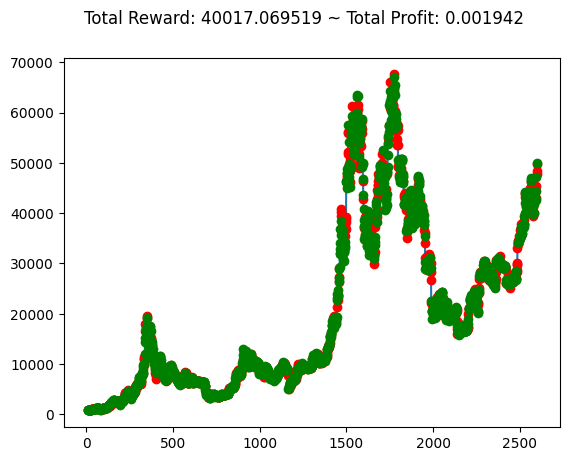

In [7]:
state = env.reset()
observation = env.reset(seed=2024)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

##Now instead of random action we want to train a RL model

## We can add some costume indicators to improve the the performance if the model

In [8]:
!pip install finta

In [9]:
from gym_anytrading.envs import StocksEnv
from finta import TA

#Calculate SMA, RSI and OBV
bitcoin_data['SMA'] = TA.SMA(bitcoin_data, 12)
bitcoin_data['RSI'] = TA.RSI(bitcoin_data)
bitcoin_data['OBV'] = TA.OBV(bitcoin_data)
bitcoin_data.fillna(0, inplace=True)
bitcoin_data.head(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008,0.000000,0.000000,0.0
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992,0.000000,100.000000,222184992.0
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000,0.000000,100.000000,407352992.0
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984,0.000000,100.000000,752298976.0
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008,0.000000,49.897498,242099968.0
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,902.200989,351876000,0.000000,35.030639,-109776032.0
2017-01-07,903.487000,908.585022,823.556030,908.585022,908.585022,279550016,0.000000,36.206016,169773984.0
2017-01-08,908.174988,942.723999,887.249023,911.198975,911.198975,158715008,0.000000,36.710892,328488992.0
2017-01-09,913.244019,913.685974,879.807007,902.828003,902.828003,141876992,0.000000,35.735525,186612000.0


##Creating the new envirement with the new features

In [10]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [11]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MyCustomEnv(df=bitcoin_data, frame_bound=(10,2600), window_size=10)

In [12]:
env2.signal_features

array([[9.58698975e+02, 1.47775008e+08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [9.96702026e+02, 2.22184992e+08, 0.00000000e+00, 1.00000000e+02,
        2.22184992e+08],
       [1.02159998e+03, 1.85168000e+08, 0.00000000e+00, 1.00000000e+02,
        4.07352992e+08],
       ...,
       [4.76174062e+04, 1.93158671e+10, 4.44162995e+04, 7.47637259e+01,
        1.46417781e+12],
       [4.77457617e+04, 3.45119858e+10, 4.50309342e+04, 7.86805305e+01,
        1.49868979e+12],
       [4.84064961e+04, 3.55930515e+10, 4.55864899e+04, 7.70116372e+01,
        1.46309674e+12]])

In [13]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [14]:
# stop running whe the model reach a stable training threshold
stop_callback= StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)

# check training and evaluate preformence until the threshold has been met
eval_callback = EvalCallback(
    env,
    callback_on_new_best=stop_callback,
    eval_freq=10000,
    verbose=1
)

model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=1000000, callback=eval_callback)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 478      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0.00134  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 89.7     |
|    value_loss         | 2.55e+04 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 507      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 0.00357  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -23.4    |
|    value_loss      

KeyboardInterrupt: 

In [ ]:

env = MyCustomEnv(df=bitcoin_data, window_size=12, frame_bound=(80,250))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()